In this tutorial, I am going to introduce a wisely used Machine Learning algorithm in data science area in the industry, Gradient Boosting Decision Tree(GBDT) and its improved versions XGBoost and LightGBM. The brief introduction of GBDT will be given first, and how it is applied to a real dataset for prediction and feature analysis will be demonstrated subsequently. Lately, how XGBoost improves GBDT and how LightGBM improves XGBoost will be shown. Finally, the results of applying these three algorithms on the same dataset will be compared in terms of execution time and accuracy. 

## Tutorial Content

After following this tutorial, you should know:
        - how GBDT works.
        - how to apply GBDT to a real task and do feature analysis and selection.
        - how xgboost improves GBDT.
        - how lightGBM improves xgboost.

- [GBDT](#GBDT)
- [Tasks with GBDT](#Tasks-with-GBDT)
- [XGBoost](#XGBoost)
- [LightGBM](#LightGBM)
- [Results Comparison and Conclusion](#Results-Comparison-Conclusion)
- [Reference](#Reference)

## GBDT
Gradient boosting is a generic technique that generates a powerful model by using an ensemble of multiple arbitrary week learners. Combining this technique with regression tree, GBDT [1] (also called GBRT, GBM) creates powerful prediction models for classification and regression. It trains a series of small trees and each tree is trained to correct the mistakes of the previous trees in the series. The tree is generated by choosing the best split points based on purity scores like Gini, while the model is constructed in an additive manner, that one tree is added at a time and the previous trees remain unchanged. The final prediction of the model is a weighted average prediction of these weak regression trees. 

The following is a popular example of explaining how  GBDT works. Given features like age, gender, occupation, and if user computer daily, etc., we can predict if someone will like games. 

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png" width="500" height="500" />

Initially, every sample is in the root node. When splitting a node, each value of each feature will be examined based on purity scores like Gini. The value that generates maximal scores will be chosen as the split point. 

As the above figure shows, age 15 is the most apparent feature that can divide people like computer games and do not like computer games, so it is chosen as the split point for the root node. Whether one node will be split is based on some criteria like minimum number of samples in the node, maximum information gain or minimum impurity decrease for splitting the node, maximum number of leaf nodes, etc. These criteria depend on implementation. Most of them are implemented in open source library, like sklearn. So they can be tuned as hyperparameters. And how deep the tree (depth) can grow is also an import hyperparameter to tune.  

Come back to the example, with certain constraints, people are classified into different leaves with a score assigned to each leaf.  

All above constraints will influence the growth of the tree and help to deal with overfitting. As you might know, the most significant problem with single decision tree is overfitting. A tree could grow very deeply to fit the data as a small tree perform badly. When the tree becomes too big, the generalization becomes a problem. However, trees have the nice property of interpretation and work well for general purpose tasks. The ensemble idea brings decision tree come to life. Instead of having a deep single tree, the ensemble model has multiple small trees.  

The following figure shows how the ensemble of two trees makes the prediction by adding the prediction of each small tree.  

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png" width="500" height="500" />

The number of trees in the model is also an important hyperparameter to play with. It is similar with the hyperparameter epochs in the neural network. 


## Tasks with GBDT

As discussed above, GBDT algorithms might be different in terms of implementation. Here I use the GBDT algorithm from scikit-learn. The algorithm is implemented as [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html). They are used for classification task and regression task respectively. 


The dataset I am going to use to test the algorithm is commonly used dataset [MNIST handwritten digits](https://en.wikipedia.org/wiki/MNIST_database). You can download the data from this [link](http://deeplearning.net/data/mnist/mnist.pkl.gz). 

In [1]:
import gzip
import pickle as pkl
from sklearn.model_selection import train_test_split

def load_data(path):
    f = gzip.open(path, 'rb')
    try:
        #Python3
        train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    except:
        #Python2
        train_set, valid_set, test_set = pkl.load(f)
    f.close()
    return(train_set,valid_set,test_set)

path = 'mnist.pkl.gz' 
train_set,valid_set,test_set = load_data(path)

# due to computation resource limitation, sample 10% data for this tutorial
Xtrain,_,ytrain,_ = train_test_split(train_set[0], train_set[1], test_size=0.9)
Xtest,_,ytest,_ = train_test_split(test_set[0], test_set[1], test_size=0.9)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(5000, 784) (5000,) (1000, 784) (1000,)


As this dataset is for classification task, I use GradientBoostingClassifier. Before applying an algorithm, we have to know about the hyperparameters and how they affect the algorithm. Here is a list of hyperparameters for this classifier:

- **learning_rate**: The learning parameter controls the magnitude of this change in the estimates. (default=0.1)
- **n_extimators**: The number of sequential trees to be modeled. (default=100)
- **max_depth**: The maximum depth of a tree. (default=3)
- **min_samples_split**: Tthe minimum number of samples (or observations) which are required in a node to be considered for splitting. (default=2)
- **min_samples_leaf**: The minimum samples (or observations) required in a terminal node or leaf. (default=1)
- **min_weight_fraction_leaf**: Similar to min_samples_leaf but defined as a fraction of the total number of observations instead of an integer. (default=0.)
- **subsample**: The fraction of observations to be selected for each tree. Selection is done by random sampling. (default=1.0)
- **max_features**: The number of features to consider while searching for a best split. These will be randomly selected. (default=None)
- **max_leaf_nodes**: The maximum number of terminal nodes or leaves in a tree. (default=None)
- **min_impurity_decrease**: A node will be split if this split induces a decrease of the impurity greater than or equal to this value. (default=0.)

Other parameters that are not relevant to the training process are not listed here. From the hyperparameters, we can have a sense of how the algorithm is implemented. 

An unnecessary evil to use a classifier is tuning hypermeters to achieve the best performance. Since this tutorial does not focus on improving performance but the comparison of three similar algorithms, I will use the default setting and only change the number of trees to make it consistent among three algorithms. The criteria I use to compare are the training time and accuracy. 

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import time 

clf = GradientBoostingClassifier(n_estimators=10, 
                                 learning_rate=0.1, 
                                 max_depth=3)

# start training
start_time = time.time()
clf.fit(Xtrain, ytrain)
end_time = time.time()
print('The training time = {}'.format(end_time - start_time))

# prediction and evaluation 
pred = clf.predict(Xtest)
accuracy = np.sum(pred == ytest) / pred.shape[0]
print('Test accuracy = {}'.format(accuracy))

The training time = 19.93053889274597
Test accuracy = 0.833


A nice property of GBDT is that feature importance can be provided after training. It is evaluated by counting in how many trees a feature is split. In sklearn, we can extract the feature importance from the classifier using clf.feature\_importances\_ and it is given as the percentage rather than the count. Below, the histogram of feature importance is shown.

0.0222245992562 0.0


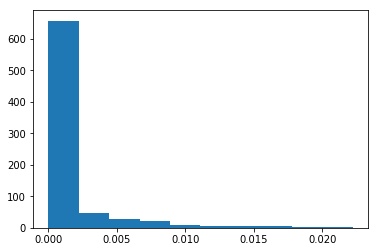

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(clf.feature_importances_)
print(max(clf.feature_importances_), min(clf.feature_importances_))

We can find that most of the features do not make any contributions to build the tree. Another thing data scientists usually do is to filter the features based on the feature importance. 

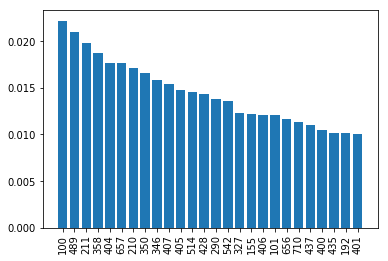

In [14]:
from collections import OrderedDict
d = {}
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > 0.01:
        d[i] = clf.feature_importances_[i]

sorted_feature_importances = OrderedDict(sorted(d.items(), key=lambda x:x[1], reverse=True))
D = sorted_feature_importances
rects = plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys(),rotation=90)
plt.show()

This visualization can help us better know what features are important and how important they are. The dataset we are using is images. So one feature corresponds to one pixel. In some general purpose application, like house price prediction, the features might be the size of the house, the location of the house, etc. With feature importance, we can know which feature is most relevant to house price. 

Feature selection based on feature importance might help to reduce the feature space and make training faster. But we are actually losing information. I would do feature selection only if I have too many features and many of them are useless. 

## XGBoost

XGBoost [2] provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. If you read this paper, you will find that the most significant part is that XGBoost formally defines an objective function using gradient statistics including first level gradient (Gradient) and second level gradient (Hessian). For input samples, we can calculate the corresponding G and H, push them to the leaves they belong to and sum them up to evaluate how good a tree is (as shown in the following figure). The nice thing about the objective function is that we can add regularization terms to it to control model complexity, like adding L1 or L2 penalty to linear models. XGBoost adds the penalty to the number of leaves and scores on leaves in the objective function.

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/struct_score.png" width="500" height="500" />

Besides accuracy, fast is also a significant feature of XGBoost. The underlying implementation is C and it makes full use of available computing resources and supports parallel processing. Living in a world of big data, data become more and more, it is very inefficient to train with low speed. That is why XGBoost is so popular in Kaggle competition. 

Following [this guide](https://xgboost.readthedocs.io/en/latest/build.html#), you would be able to install xgboost as a python package. 


In [11]:
import xgboost as xgb
import numpy as np
import time

# read data into Xgboost DMatrix format
dtrain = xgb.DMatrix(Xtrain, label=ytrain)
dtest = xgb.DMatrix(Xtest, label=ytest)

# specify parameters via map
params = {
    'booster':'gbtree',     #  tree-based models
    'objective': 'multi:softmax', 
    'num_class':10, 
    'eta': 0.1,             # Same to learning rate
    'gamma':0,              # Similar to min_impurity_decrease in GBDT
    'alpha': 0,             # L1 regularization term on weight (analogous to Lasso regression)
    'lambda': 2,            # L2 regularization term on weights (analogous to Ridge regression)
    'max_depth': 3,         # Same as the max_depth of GBDT
    'subsample': 1,         # Same as the subsample of GBDT
    'colsample_bytree': 1,  # Similar to max_features in GBM
    'min_child_weight': 1,  # minimum sum of instance weight (Hessian) needed in a child
    'nthread':1,            # default to maximum number of threads available if not set
}
num_round = 10

# start training
start_time = time.time()
bst = xgb.train(params, dtrain, num_round)
end_time = time.time()
print('The training time = {}'.format(end_time - start_time))

# get prediction and evaluate
ypred = bst.predict(dtest)
accuracy = np.sum(ypred == ytest) / ypred.shape[0]
print('Test accuracy = {}'.format(accuracy))


The training time = 7.43514609336853
Test accuracy = 0.839


Above you can find that xgboost has more hyperparameters than GBDT, like alpha, lambda, and min_child_weight due to the additional implementations. Alpha and lambda are used to control regularization, and min_child_weight is another criteria to control node split as a result of using second level gradient Hessian. Wonder about other parameters? Check [this](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

## LightGBM

LightGBM [3] is open sourced by Microsoft. It further optimizes xgboost's executing efficiency by reducing calculation cost of split gain, using histogram subtraction for speed-up, reducing memory usage, and reducing communication cost for parallel learning. Check out the paper, it is really impressive.   

The most significant change for increasing accuracy is using leaf-wise tree growth instead of level-wise tree growth. GBDT and XGBoost have constraints on the max depth of the tree, while LightGBM set it None as default. From the following two figures, you can find the difference. 
<img src="https://lightgbm.readthedocs.io/en/latest/_images/level-wise.png" width="400" height="400" />
<img src="https://lightgbm.readthedocs.io/en/latest/_images/leaf-wise.png" width="500" height="500" />
Leaf-wise tree growth only split the node with the maximum split gain using a priority queue, while level-wise tree growth split every leaf node if it is splittable. Leaf-wise learning can fit data better and eliminate unhelpful split. 


Follow [this guide](https://github.com/Microsoft/LightGBM/tree/master/python-package) to install lightGBM as a python package. 


In [12]:
import lightgbm as lgb
train_data = lgb.Dataset(Xtrain, label=ytrain)
test_data = lgb.Dataset(Xtest, label=ytest)

# specify parameters via map
params = {
    'num_leaves':31,                # Same to max_leaf_nodes in GBDT, but GBDT's default value is None
    'max_depth': -1,                # Same to max_depth of xgboost
    'tree_learner': 'serial', 
    'application':'multiclass',     # Same to objective of xgboost
    'num_class':10,                 # Same to num_class of xgboost
    'learning_rate': 0.1,           # Same to eta of xgboost
    'min_split_gain': 0,            # Same to gamma of xgboost
    'lambda_l1': 0,                 # Same to alpha of xgboost
    'lambda_l2': 0,                 # Same to lambda of xgboost
    'min_data_in_leaf': 20,         # Same to min_samples_leaf of GBDT
    'bagging_fraction': 1.0,        # Same to subsample of xgboost
    'bagging_freq': 0,
    'bagging_seed': 0,
    'feature_fraction': 1.0,         # Same to colsample_bytree of xgboost
    'feature_fraction_seed': 2,
    'min_sum_hessian_in_leaf': 1e-3, # Same to min_child_weight of xgboost
    'num_threads': 1
}
num_round = 10

# start training
start_time = time.time()
bst = lgb.train(params, train_data, num_round)
end_time = time.time()
print('The training time = {}'.format(end_time - start_time))

# get prediction and evaluate
ypred_onehot = bst.predict(Xtest)
ypred = []
for i in range(len(ypred_onehot)):
    ypred.append(ypred_onehot[i].argmax())

accuracy = np.sum(ypred == ytest) / len(ypred)
print('Test accuracy = {}'.format(accuracy))

The training time = 5.919008016586304
Test accuracy = 0.892


Due to leaf-wise tree growth, the primary key to control the tree structure is num_leaves rather than max_depth. Leaf-wise tree growth can achieve better accuracy but easily overfit the data. To address this problem, LightGBM implements many tricks, like dropout, control bagging frequency, etc. There are much more parameters than listed above to help addressing overfitting. Check [this link](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst) for all parameters.  

## Results Comparison and Conclusion

With the same data, number of trees and the number of thread, the training time and accuracy of three algorithms are shown in the table. 

|          | time(s) | accuracy(%) |
|----------|---------|-------------|
| GBDT     | 19.93   | 0.833       |
| XGBoost  | 7.43    | 0.839       |
| LightGBM | 5.92    | 0.892       |

In terms of training time, xgboost significantly reduces the training time even thought only one thread is used. LightGBM further shortens the time.  

In terms of accuracy, current experiments are not sufficient to make any conclusion as the hyperparameters are not tuned to achieve the best performance. But we can still have some analysis of the results. It is reasonable that xgboost behavior better than GBDT as it involves second level gradient Hessian. And xgboost should perform better in the long-term training as it applies regularization techniques. There is no doubt that LightGBM performs best in the first 10 runs as a result of leaf-wise tree growth. 

This tutorial provides brief information about three algorithms. Want to explore more about the underlying theory and system architecture? Check the paper and source code in Reference. 

Happy training! :)

## Reference

[1] Friedman, Jerome H. "[Greedy function approximation: a gradient boosting machine.](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)" Annals of statistics (2001): 1189-1232.   
[2] Chen, Tianqi, and Carlos Guestrin. "[Xgboost: A scalable tree boosting system.](https://arxiv.org/pdf/1603.02754.pdf)" In Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining, pp. 785-794. ACM, 2016.   
[3] Ke, Guolin, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, and Tie-Yan Liu. "[LightGBM: A highly efficient gradient boosting decision tree.](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf)" In Advances in Neural Information Processing Systems, pp. 3149-3157. 2017.   
[4] GBDT source code:  https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/gradient_boosting.py#L1189   
[5] XGBoost source code: https://github.com/dmlc/xgboost    
[6] LightGBM source code: https://github.com/Microsoft/LightGBM  